# CIFAR-100 "from scratch"

In [27]:
from __future__ import absolute_import, division, print_function, unicode_literals # legacy compatibility

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

## Βοηθητικός Κώδικας

In [28]:
#@title
# helper functions

# select from from_list elements with index in index_list
def select_from_list(from_list, index_list):
    filtered_list= [from_list[i] for i in index_list]
    return(filtered_list)

# append in filtered_list the index of each element of unfilterd_list if it exists in in target_list
def get_ds_index(unfiliterd_list, target_list):
    index = 0
    filtered_list=[]
    for i_ in unfiliterd_list:
        if i_[0] in target_list:
            filtered_list.append(index)
        index += 1
    return(filtered_list)

# select a url for a unique subset of CIFAR-100 with 20, 40, 60, or 80 classes
def select_classes_number(classes_number = 20):
    cifar100_20_classes_url = "https://pastebin.com/raw/nzE1n98V"
    cifar100_40_classes_url = "https://pastebin.com/raw/zGX4mCNP"
    cifar100_60_classes_url = "https://pastebin.com/raw/nsDTd3Qn"
    cifar100_80_classes_url = "https://pastebin.com/raw/SNbXz700"
    if classes_number == 20:
        return cifar100_20_classes_url
    elif classes_number == 40:
        return cifar100_40_classes_url
    elif classes_number == 60:
        return cifar100_60_classes_url
    elif classes_number == 80:
        return cifar100_80_classes_url
    else:
        return -1

In [29]:
# load the entire dataset
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

In [30]:
# REPLACE WITH YOUR C NUMBER
team_sead = 10

In [31]:
# select the number of classes
cifar100_classes_url = select_classes_number(80)

In [32]:
# create dataset
my_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None)
CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt', sep=',', header=None).astype(str).values.tolist()[0]

our_index = my_classes.iloc[team_sead,:].values.tolist()
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)
train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

In [33]:
# print our classes
print(our_classes)
CLASSES_NUM=len(our_classes)

['apple', ' beaver', ' bee', ' beetle', ' bottle', ' bowl', ' boy', ' bridge', ' bus', ' butterfly', ' camel', ' can', ' castle', ' caterpillar', ' cattle', ' chair', ' chimpanzee', ' clock', ' cockroach', ' couch', ' crab', ' crocodile', ' cup', ' dinosaur', ' flatfish', ' forest', ' fox', ' girl', ' hamster', ' kangaroo', ' keyboard', ' lamp', ' leopard', ' lion', ' lizard', ' lobster', ' man', ' maple_tree', ' motorcycle', ' mountain', ' mushroom', ' oak_tree', ' orange', ' orchid', ' otter', ' palm_tree', ' pickup_truck', ' pine_tree', ' plain', ' plate', ' poppy', ' porcupine', ' possum', ' rabbit', ' raccoon', ' ray', ' road', ' rocket', ' sea', ' seal', ' shark', ' shrew', ' skunk', ' skyscraper', ' snail', ' snake', ' squirrel', ' streetcar', ' sweet_pepper', ' table', ' tank', ' telephone', ' tiger', ' tractor', ' train', ' tulip', ' turtle', ' whale', ' willow_tree', ' woman']


6000
Train: X=(34000, 32, 32, 3), y=(34000, 1)
Validation: X=(6000, 32, 32, 3), y=(6000, 1)
Test: X=(8000, 32, 32, 3), y=(8000, 1)


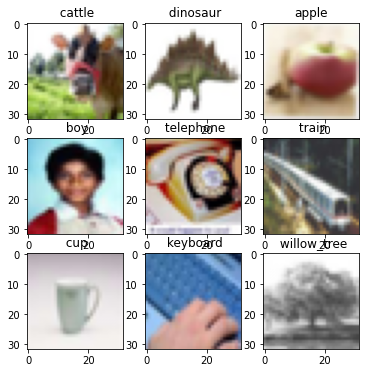

In [34]:
# train/val/test splits

# get (train) dataset dimensions
data_size, img_rows, img_cols, img_channels = x_train_ds.shape

# get (test) dataset dimensions
test_size = x_test_ds.shape[0]

# set validation set percentage (wrt the training set size)
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

print(len(x_val))

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# get class label from class index
def class_label_from_index(fine_category):
    return(CIFAR100_LABELS_LIST[fine_category.item(0)])

# plot first few images
plt.figure(figsize=(6, 6))
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i).set_title(class_label_from_index(y_train[i]))
    # plot raw pixel data
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
#show the figure
plt.show()

### Συναρτήσεις εκπαίδευσης

In [35]:
# we user prefetch https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch 
# see also AUTOTUNE
# the dataset is now "infinite"

BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

def _input_fn(x,y, BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices((x,y))
    ds = ds.shuffle(buffer_size=data_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds =_input_fn(x_train,y_train, BATCH_SIZE) #PrefetchDataset object
validation_ds =_input_fn(x_val,y_val, BATCH_SIZE) #PrefetchDataset object
test_ds =_input_fn(x_test,y_test, BATCH_SIZE) #PrefetchDataset object

# steps_per_epoch and validation_steps for training and validation: https://www.tensorflow.org/guide/keras/train_and_evaluate

def train_model(model, epochs = 10, steps_per_epoch = 2, validation_steps = 1):
    callback = callbacks.EarlyStopping(monitor='val_loss', patience=5)
    start = time.time()
    history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=validation_steps, callbacks=[callback])
    end = time.time()
    print("\nTrain time:", round(end - start), 'seconds')
    return(history)

### Γραφικές παραστάσεις εκπαίδευσης και απόδοση στο σύνολο ελέγχου

In [36]:
#@title
# plot diagnostic learning curves
def summarize_diagnostics(history):
    plt.figure(figsize=(8, 8))
    plt.suptitle('Training Curves')
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend(loc='upper right')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='val')
    plt.legend(loc='lower right')
    return plt
 
# print test set evaluation metrics
def model_evaluation(model, evaluation_steps):
    print('\nTest set evaluation metrics')
    loss0,accuracy0 = model.evaluate(test_ds, steps = evaluation_steps)
    print("loss: {:.2f}".format(loss0))
    print("accuracy: {:.2f}".format(accuracy0))

def model_report(model, history, evaluation_steps = 10):
    plt = summarize_diagnostics(history)
    plt.show()
    model_evaluation(model, evaluation_steps)

## CNN "from scratch"

In [37]:
# define model
def init_cnn(summary):
    inputs = tf.keras.Input(shape=(32, 32, 3), name='input')
    
    # Block 1
    x = layers.Conv2D(64, (3, 3), padding='same', name='block1_conv')(inputs)    
    x = layers.BatchNormalization(axis=3, name='block1_bn')(x)
    x = layers.MaxPooling2D((2, 2), name='block1_pool')(x)
    x = layers.Activation('relu', name='block1_act')(x)
  
    # Block 2
    x = layers.Conv2D(128, (3, 3), padding='same', name='block2_conv')(x)
    x = layers.BatchNormalization(axis=3, name='block2_bn')(x)
    x = layers.MaxPooling2D((2, 2), name='block2_pool')(x)
    x = layers.Activation('relu', name='block2_act')(x)
    
    # Block 3
    x = layers.Conv2D(256, (3, 3), padding='same', name='block3_conv')(x)
    x = layers.BatchNormalization(axis=3, name='block3_bn')(x)
    x = layers.MaxPooling2D((2, 2), name='block3_pool')(x)
    x = layers.Activation('relu', name='block3_act')(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3), padding='same', name='block4_conv')(x)
    x = layers.BatchNormalization(axis=3, name='block4_bn')(x)
    x = layers.MaxPooling2D((2, 2), name='block4_pool')(x)
    x = layers.Activation('relu', name='block4_act')(x)
      
    # Classification block
    x = layers.GlobalMaxPooling2D(name='max_pool')(x)
    outputs = layers.Dense(100, activation='softmax', name='predictions')(x)
  
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
    if summary: 
        model.summary()
    return model

In [38]:
# train model
model = init_cnn(summary = True)
history = train_model(model, 100, data_size//BATCH_SIZE, val_size//BATCH_SIZE)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv (Conv2D)         (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_bn (BatchNormalizatio (None, 32, 32, 64)        256       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block1_act (Activation)      (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv (Conv2D)         (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_bn (BatchNormalizatio (None, 16, 16, 128)       512 

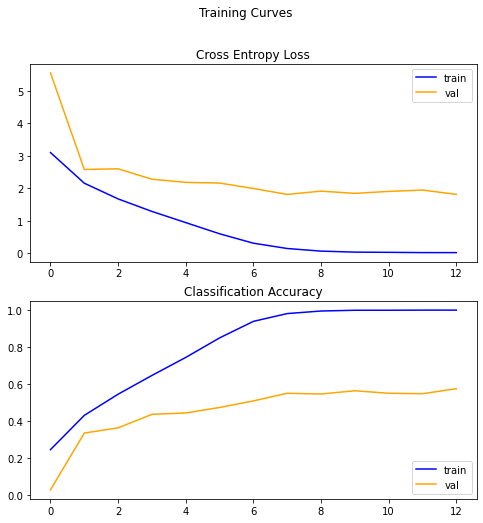


Test set evaluation metrics
62/62 [==============================] - 1s 6ms/step - loss: 1.7924 - accuracy: 0.5698
loss: 1.79
accuracy: 0.57


In [39]:
# evaluate
model_report(model, history, test_size//BATCH_SIZE)